# Lamb-like wave in the solar spectrum

This notebook computes the normal modes of the 1D Solar model used in the article written by A. Le Saux, A. Leclerc, G. Laibe, P. Delplace and A. Venaille.

In [1]:
### Packages

from dedalus import public as de
from eigentools import Eigenproblem
import numpy as np
import matplotlib.pyplot as plt
from tomso import fgong
from scipy import interpolate

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.figsize": (4,4)
})

In [2]:
### Loading external 1D solar model
model_file = 'profile_1D_sun_r15140_Z0p02.data.FGONG'
model = fgong.load_fgong(model_file, G=6.67232e-8)

In [3]:
### Functions

def getEigenMode(nuTarget,ellTarget,ells,nus,etas,modes):
    idx = ( np.abs(nus - nuTarget)/nuTarget + np.abs(ells-ellTarget)/ellTarget ).argmin()
    complexFreq = nus[idx]+j*etas[idx]
    v,w,theta,p = modes[idx]
    
    return complexFreq,ells[idx],v,w,theta,p

In [4]:
# Import parameters

Rsun = 69.634e9

print("Radius of the model: ",model.r[0]/Rsun)

r_model    = np.flip(model.r)
N2_model   = np.flip(model.N2)
g_model    = np.flip(model.g)
cs_model   = np.flip(model.cs)
rho_model  = np.flip(model.rho)

dcdr_model = np.gradient(cs_model,r_model)
S_model    = cs_model*(N2_model-(g_model/cs_model)**2)/2/g_model + cs_model/r_model -dcdr_model/2
cs_model   = cs_model/Rsun #adim of lengths
g_model    = g_model/Rsun  #adim of lengths
r_model    = r_model/Rsun  #adim of lengths

c    = interpolate.interp1d(r_model,cs_model)
dcdr = interpolate.interp1d(r_model,dcdr_model)
N2   = interpolate.interp1d(r_model,N2_model)
S    = interpolate.interp1d(r_model,S_model)
g    = interpolate.interp1d(r_model,g_model)
rho  = interpolate.interp1d(r_model,rho_model)
N    = interpolate.interp1d(r_model,np.sqrt( np.maximum(N2_model,0) ))

Radius of the model:  0.9996762585860501


/tmp/ipykernel_807869/1909118636.py:14: RuntimeWarning: invalid value encountered in divide
  S_model    = cs_model*(N2_model-(g_model/cs_model)**2)/2/g_model + cs_model/r_model -dcdr_model/2
/tmp/ipykernel_807869/1909118636.py:14: RuntimeWarning: divide by zero encountered in divide
  S_model    = cs_model*(N2_model-(g_model/cs_model)**2)/2/g_model + cs_model/r_model -dcdr_model/2


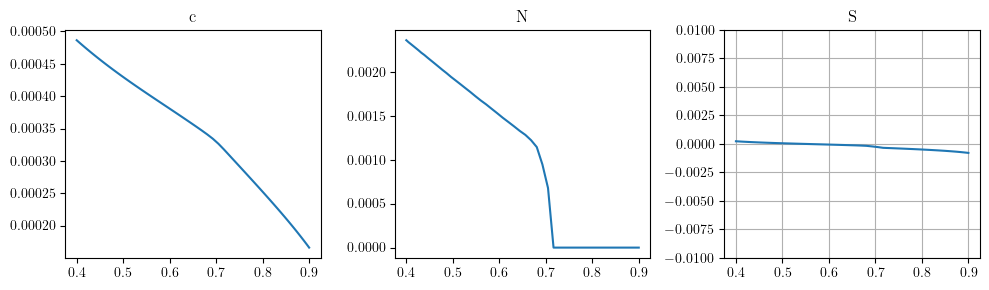

In [5]:
# Parameters
%matplotlib inline 

muHzFromPuls = 1e6/2/np.pi 
j            = complex(0,1)

Nr               = 64
spaceElls        = np.linspace(0,20,20+1) #angular wavenumbers
Rin              = 0.4
Rout             = 0.9
outer_BC         = "rigid" #"free_surface" or "rigid"
driftThresh      = 1e4     # threshold of convergence of modes (see Eigentools)
ncc_cutoff_waves = 1e-15

rbasis = de.Chebyshev('r', Nr, interval = (Rin,Rout))
r = rbasis.grid(scale=1)

fig,axs = plt.subplots(1,3,figsize=(10,3))
axs[0].plot(r,c(r))
axs[0].set_title("c")
axs[1].plot(r,N(r))
axs[1].set_title("N")
axs[2].plot(r,S(r))
axs[2].set_title("S")
axs[2].set_ylim((-1e-2,1e-2))
axs[2].grid()
plt.tight_layout()
plt.show()

In [6]:
### Simulation
%matplotlib inline
ells, nus, etas, modes = [],[],[],[]

rbasis = de.Chebyshev('r', Nr, interval = (Rin,Rout))
domain = de.Domain([rbasis],  mesh=[1]) 
r = rbasis.grid(scale=1) #spatial points for plots

#solving a problem for every value of ell

for ℓ in spaceElls:

    #setting up EVP problem
    problem = de.EVP(domain, 
                     variables=['v','w','θ','p'], 
                     eigenvalue='σ', 
                     ncc_cutoff=ncc_cutoff_waves)
    problem.meta[:]['r']['dirichlet'] = True

    #parameters
    csound      = domain.new_field(name='cs')
    csound['g'] = c(r)
    dcsdr       = domain.new_field(name='dcdr')
    dcsdr['g']  = dcdr(r)
    bruntV      = domain.new_field(name='N')
    bruntV['g'] = N(r)
    strat       = domain.new_field(name='S')
    strat['g']  = 1*S(r)
    lamb        = domain.new_field(name='Ll')
    lamb['g']   = csound['g'] * np.sqrt(ℓ*(ℓ+1))/(r)

    problem.parameters['cs']    = csound
    problem.parameters['dcdr']  = dcsdr
    problem.parameters['N']     = bruntV
    problem.parameters['S']     = strat
    problem.parameters['Ll']    = lamb
    problem.parameters['cout']  = c([Rout])[0]
    problem.parameters['gout']  = g([Rout])[0]
    problem.parameters['j']     = complex(0,1)


    #system of eqs
    problem.add_equation("-σ*v +                                 Ll*p  =  0")
    problem.add_equation("-σ*w + j*N*θ -j*S*p + j*cs*dr(p)+j*dcdr*p/2  =  0")
    problem.add_equation("-σ*θ - j*N*w                                 =  0")
    problem.add_equation("-σ*p + Ll*v +j*S*w + j*cs*dr(w)+j*dcdr*w/2   =  0")


    #BCs
    problem.add_bc("left(w)  =0")
    if outer_BC == "rigid":
        problem.add_bc("right(w) =0")
    if outer_BC == "free_surface":
        problem.add_bc("right(j*σ*cout*p - gout*w) =0")

    #solving
    EP = Eigenproblem(problem,reject=True, drift_threshold=driftThresh, use_ordinal=False)
    EP.solve(sparse=False)
#     EP.plot_drift_ratios()  #plot selection of "well-converged" modes
#     plt.show()
    
    freqs = EP.evalues
    order = range(len(freqs))
    print("----- I find {} modes for ℓ={:.1f}".format(len(freqs),ℓ))

    #recording results
    ells     +=[ℓ                 for i in order]
    nus      +=[np.real(freqs[i])*muHzFromPuls for i in order]
    etas     +=[np.imag(freqs[i])*muHzFromPuls for i in order]
    modes    +=[ [np.copy(EP.eigenmode(i).fields[0]['g']),np.copy(EP.eigenmode(i).fields[1]['g']),np.copy(EP.eigenmode(i).fields[2]['g']),np.copy(EP.eigenmode(i).fields[3]['g'])] for i in order]

    

nus,etas,modes,ells = np.array(nus),np.array(etas),np.array(modes),np.array(ells)
print("----------------")
print("Done!")

2024-09-13 15:13:36,492 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2024-09-13 15:13:36,517 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
----- I find 71 modes for ℓ=0.0
2024-09-13 15:13:37,811 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2024-09-13 15:13:37,824 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


/home/alecle02/miniconda3/lib/python3.9/site-packages/eigentools/eigenproblem.py:694: RuntimeWarning: divide by zero encountered in double_scalars
  self.delta_ordinal = np.array([np.abs(eval_low_sorted[j] - eval_hi_sorted[j])/sigmas[j] for j in range(len(eval_low_sorted))])
/home/alecle02/miniconda3/lib/python3.9/site-packages/eigentools/eigenproblem.py:694: RuntimeWarning: invalid value encountered in double_scalars
  self.delta_ordinal = np.array([np.abs(eval_low_sorted[j] - eval_hi_sorted[j])/sigmas[j] for j in range(len(eval_low_sorted))])
/home/alecle02/miniconda3/lib/python3.9/site-packages/eigentools/eigenproblem.py:697: RuntimeWarning: divide by zero encountered in divide
  self.delta_near = np.array([np.nanmin(np.abs(eval_low_sorted[j] - eval_hi_sorted)/sigmas[j]) for j in range(len(eval_low_sorted))])
/home/alecle02/miniconda3/lib/python3.9/site-packages/eigentools/eigenproblem.py:697: RuntimeWarning: invalid value encountered in divide
  self.delta_near = np.array([np.nanmi

----- I find 83 modes for ℓ=1.0
2024-09-13 15:13:39,408 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2024-09-13 15:13:39,422 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
----- I find 84 modes for ℓ=2.0
2024-09-13 15:13:41,072 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2024-09-13 15:13:41,087 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
----- I find 83 modes for ℓ=3.0
2024-09-13 15:13:42,699 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2024-09-13 15:13:42,715 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
----- I find 83 modes for ℓ=4.0
2024-09-13 15:13:44,361 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2024-09-13 15:13:44,375 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
----- I find 84 modes for ℓ=5.0
2024-09-13 15:13:46,026 problems 0/1 INFO :: Solving EVP with ho

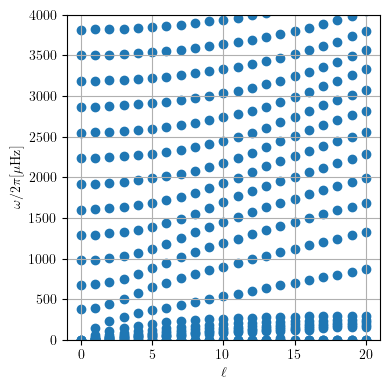

In [7]:
### Plot of frequencies against harmonic degree

nuMaxPlot = 4000

fig,ax = plt.subplots(1,1)
img = ax.scatter(ells,nus)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\omega/2\pi[\mu\mathrm{Hz}]$")
ax.set_ylim((0,nuMaxPlot))

plt.grid()
plt.tight_layout()
plt.show()

Frequency =  (365.647-0j) , ell =  5.0


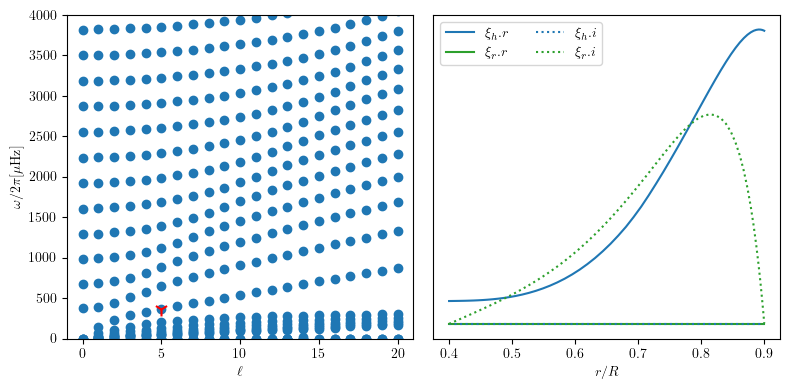

In [8]:
### Plot of an eigenmode

# aim for an eigenmode in the dispersion relation, located at (ellTarget,nuTarget)
# function getEigenMode shows the eigenfunctions of the closest one
ellTarget = 5
nuTarget  = 400

complexFreqFound,ellFound,vh,vr,θ,p = getEigenMode(nuTarget,ellTarget,ells,nus,etas,modes)
nuFound = complexFreqFound.real
print("Frequency = ",np.round(complexFreqFound,3),r", ell = ",round(ellFound,3))
phaseRandom = np.angle(vh[0])
vh,vr,θ,p = vh*np.exp(-j*phaseRandom),vr*np.exp(-j*phaseRandom),θ*np.exp(-j*phaseRandom),p*np.exp(-j*phaseRandom)

### Frequencies plot to eye-check which mode we found
fig,axs = plt.subplots(1,2,figsize=(8,4))
axs[0].set_xlabel(r"$\ell$")
axs[0].set_ylabel(r"$\omega/2\pi[\mu\mathrm{Hz}]$")
img = axs[0].scatter(ells,nus)
axs[0].scatter([ellFound],[nuFound],s=100,c='red',marker='1')
axs[0].set_ylim((0,nuMaxPlot))

axs[1].set_xlabel(r"$r/R$")
axs[1].set_yticks(())
axs[1].plot(r,vh.real/r/np.sqrt(rho(r)),c="tab:blue",label=r"$\xi_h.r$")
axs[1].plot(r,vr.real/r/np.sqrt(rho(r)),c="tab:green",label=r"$\xi_r.r$")
axs[1].plot(r,vh.imag/r/np.sqrt(rho(r)),c="tab:blue",label=r"$\xi_h.i$",linestyle=':')
axs[1].plot(r,vr.imag/r/np.sqrt(rho(r)),c="tab:green",label=r"$\xi_r.i$",linestyle=':')

plt.legend(ncol=2)
plt.tight_layout()
# plt.savefig("osef.pdf")
plt.show()